## Heat Eq with 2-parameter kernel


$\mathcal{L}_{\bar{x}}^{\phi}u(\bar{x}) = \frac{\partial}{\partial t}u(\bar{x}) - \phi \frac{\partial^2}{\partial x^2}u(\bar{x}) = f(\bar{x})$, where $\bar{x} = (t, x) \in \mathbb{R}^2$

$u(x,t) = e^{-t}sin(2\pi x)$

$f(x,t) = e^{-t}(4\pi^2 - 1)sin(2\pi x)$


#### Step 1: simulate data

In [120]:
import time
import numpy as np
import sympy as sp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

In [2]:
n = 10
np.random.seed(int(time.time()))
t = np.random.rand(n)
x = np.random.rand(n)

In [3]:
#y_u = 2*np.square(x_u) + np.multiply(x_u, t_u) + np.random.normal(0,1, x_u.size)
#y_f = x_f - 4*12.0 + np.random.normal(0,1, x_f.size)

y_u = np.multiply(np.exp(-t), np.sin(2*np.pi*x))
y_f = (4*np.pi**2 - 1) * np.multiply(np.exp(-t), np.sin(2*np.pi*x))

#### Step 2: evaluate kernels and covariance matrix

Declare symbols

In [4]:
x_i, x_j, t_i, t_j, theta1, theta2, phi = sp.symbols('x_i x_j t_i t_j theta1 theta2 phi')

$k_{uu}(x_i, x_j, t_i, t_j; \theta) =  exp \left[ -\theta_1 (x_i-x_j)^2 - \theta_2 (t_i-t_j)^2 \right]$

In [5]:
kuu_sym = sp.exp(-theta1*(x_i - x_j)**2 - theta2*(t_i - t_j)**2)
kuu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2), kuu_sym, "numpy")
def kuu(t, x, theta1, theta2):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kuu_fn(x[i], x[j], t[i], t[j], theta1, theta2)
    return k

$k_{ff}(\bar{x}_i,\bar{x}_j;\theta,\phi) \\
= \mathcal{L}_{\bar{x}_i}^\phi \mathcal{L}_{\bar{x}_j}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) \\
= \mathcal{L}_{\bar{x}_i}^\phi \left[ \frac{\partial}{\partial t_j}k_{uu} - \phi \frac{\partial^2}{\partial x_j^2} k_{uu} \right] \\
= \frac{\partial}{\partial t_i}\frac{\partial}{\partial t_j}k_{uu} - \phi \left[ \frac{\partial}{\partial t_i}\frac{\partial^2}{\partial x_j^2}k_{uu} + \frac{\partial^2}{\partial x_i^2}\frac{\partial}{\partial t_j}k_{uu} \right] + \phi^2 \frac{\partial^2}{\partial x_i^2}\frac{\partial^2}{\partial x_j^2}k_{uu}$

In [6]:
kff_sym = sp.diff(kuu_sym, t_j, t_i) \
        - phi*sp.diff(kuu_sym,x_j,x_j,t_i) \
        - phi*sp.diff(kuu_sym,t_j,x_i,x_i) \
        + phi**2*sp.diff(kuu_sym,x_j,x_j,x_i,x_i)
kff_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2, phi), kff_sym, "numpy")
def kff(t, x, theta1, theta2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kff_fn(x[i], x[j], t[i], t[j], theta1, theta2, p)
    return k

$k_{fu}(\bar{x}_i,\bar{x}_j;\theta,\phi) \\
= \mathcal{L}_{\bar{x}_i}^\phi k_{uu}(\bar{x}_i, \bar{x}_j; \theta) \\
= \frac{\partial}{\partial t_i}k_{uu} - \phi \frac{\partial^2}{\partial x_i^2}k_{uu}$

In [7]:
kfu_sym = sp.diff(kuu_sym,t_i) - phi*sp.diff(kuu_sym,x_i,x_i)
kfu_fn = sp.lambdify((x_i, x_j, t_i, t_j, theta1, theta2, phi), kfu_sym, "numpy")
def kfu(t, x, theta1, theta2, p):
    k = np.zeros((t.size, t.size))
    for i in range(t.size):
        for j in range(t.size):
            k[i,j] = kfu_fn(x[i], x[j], t[i], t[j], theta1, theta2, p)
    return k

In [8]:
def kuf(t, x, theta1, theta2, p):
    return kfu(t, x, theta1, theta2, p).T

#### Step 3: create covariance matrix and NLML

```
params = [sig_u, l_u, phi]
```

In [34]:
def nlml(params, t, x, y1, y2, s):
    params = np.exp(params)
    K = np.block([
        [
            kuu(t, x, params[0], params[1]) + s*np.identity(x.size),
            kuf(t, x, params[0], params[1], params[2])
        ],
        [
            kfu(t, x, params[0], params[1], params[2]),
            kff(t, x, params[0], params[1], params[2]) + s*np.identity(x.size)
        ]
    ])
    y = np.concatenate((y1, y2))
    val = 0.5*(np.log(abs(np.linalg.det(K))) + np.mat(y) * np.linalg.inv(K) * np.mat(y).T)
    return val.item(0)

In [35]:
nlml((1,1,0), t, x, y_u, y_f, 1e-6)

7.77166474870485

In [36]:
%%timeit
nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
minimize(nlml_wp, np.random.rand(3), method="Nelder-Mead", options={'maxiter' : 5000, 'fatol' : 0.001})

3.58 s ± 856 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
def minimize_restarts(t, x, y_u, y_f, n = 10):
    nlml_wp = lambda params: nlml(params, t, x, y_u, y_f, 1e-7)
    all_results = []
    for it in range(0,n):
        all_results.append(minimize(nlml_wp, np.random.rand(3), method="Nelder-Mead", options={'maxiter' : 5000, 'fatol' : 0.001}))
    filtered_results = [m for m in all_results if 0 == m.status]
    return min(filtered_results, key = lambda x: x.fun)

In [38]:
m = minimize_restarts(t, x, y_u, y_f, 20)
m

 final_simplex: (array([[ 1.36512437, -1.33453497,  0.00559209],
       [ 1.36511233, -1.33446167,  0.00559225],
       [ 1.3651322 , -1.33450449,  0.00559056],
       [ 1.3651035 , -1.33447877,  0.00559011]]), array([-5.12812314, -5.12812313, -5.12812312, -5.12812311]))
           fun: -5.128123140919389
       message: 'Optimization terminated successfully.'
          nfev: 179
           nit: 100
        status: 0
       success: True
             x: array([ 1.36512437, -1.33453497,  0.00559209])

##### Estimated value of $\alpha$

In [39]:
np.exp(m.x[2])

1.005607758041274

### Analysis

#### Contour lines for likelihood

In [51]:
delta = 0.01
theta1_range = np.arange(1, 2, delta)
theta2_range = np.arange(-2, -1, delta)
theta1_mesh, theta2_mesh = np.meshgrid(theta1_range, theta2_range)
nlml_mesh_fn = lambda mesh1, mesh2: nlml(np.array([mesh1, mesh2, 0]), t, x, y_u, y_f, 1e-7)
nlml_mesh = np.zeros(theta1_mesh.shape)
for i in range(nlml_mesh.shape[0]):
    for j in range(nlml_mesh.shape[1]):
        nlml_mesh[i][j] = nlml_mesh_fn(theta1_mesh[i][j], theta2_mesh[i][j])

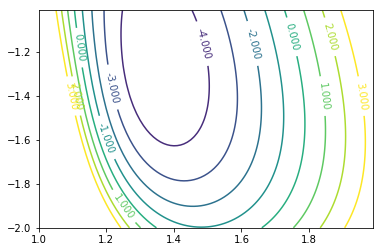

In [60]:
plt.figure()
CS = plt.contour(theta1_mesh, theta2_mesh, nlml_mesh, np.arange(-5,4))
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

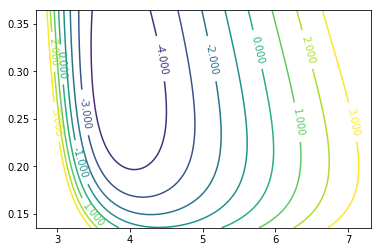

In [61]:
plt.figure()
CS = plt.contour(np.exp(theta1_mesh), np.exp(theta2_mesh), nlml_mesh, np.arange(-5,4))
plt.clabel(CS, inline=1, fontsize=10)
plt.show()

#### Profile likelihood for $\theta_1$

In [124]:
theta1_optim = np.zeros(theta1_range.size)
for i in range(theta1_range.size):
    nlml_opt_theta2 = lambda t2 : nlml(np.array([theta1_range[i], t2, 0]), t, x, y_u, y_f, 1e-7)
    m = minimize_scalar(nlml_opt_theta2)
    theta1_optim[i] = m['fun']

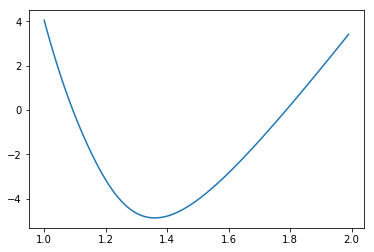

In [125]:
plt.plot(theta1_range, theta1_optim)
plt.show()

#### Profile likelihood for $\theta_2$

In [122]:
theta2_optim = np.zeros(theta2_range.size)
for i in range(theta2_range.size):
    def nlml_opt_theta1(t1):
        return nlml(np.array([t1, theta2_range[i], 0]), t, x, y_u, y_f, 1e-7)
    m = minimize_scalar(nlml_opt_theta1)
    theta2_optim[i] = m['fun']

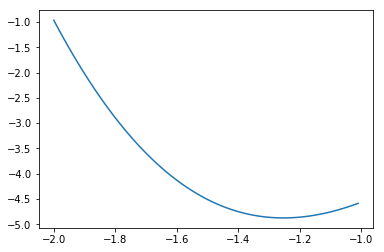

In [123]:
plt.plot(theta2_range, theta2_optim)
plt.show()